In [1]:
import pandas as pd
import numpy as np
import pathlib
import os
import cv2
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import collections
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, InputLayer, Flatten, LeakyReLU, SeparableConv2D, Activation,Conv2D , MaxPool2D  , Dropout , BatchNormalization, concatenate, Conv2DTranspose, MaxPooling2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [10]:
def process_contour(image_path):
    image= cv2.imread( image_path)
    image=cv2.resize(image, (100, 100),interpolation = cv2.INTER_AREA)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 225, 255, cv2.THRESH_BINARY_INV)
    binary = 255 - binary;
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    arr = np.zeros((200,2),dtype=float)
    if len(contours) > 1:
      contours = max(contours, key = cv2.contourArea)
      new  = np.reshape(contours[0],(np.shape(contours[0])[0],2))
      arr[:np.shape(contours[0])[0],:] = new
    else:
      new  = np.reshape(contours[0],(np.shape(contours[0])[0],2))
      arr[:np.shape(contours[0])[0],:] = new
    output = cv2.drawContours(image, contours[0], -1, (0, 255, 0), 2)    
    return arr,output
def process_raw_image(image_path):
    kernel = np.array([[0,-1,0], [-1,6,-1], [0,-1,0]])
    image= cv2.imread( image_path)
    image=cv2.resize(image, (256, 256),interpolation = cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.filter2D(image, -1, kernel)
    image=np.array(image)
    image = image.astype('float32')
    image /= 255 
    return image

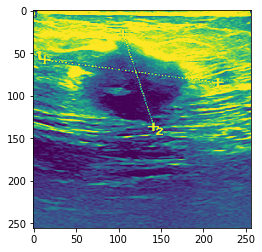

In [67]:
data,image = process_contour('mask.png')
raw_image = process_raw_image('raw.png')
# plt.imshow(image)
plt.imshow(raw_image)

In [69]:
plt.imsave('raw_image_2.png',raw_image)

In [15]:
chanDim = -1
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.01)

visible1 = Input(shape=(200,2,1))
maskc1 = Conv2D(50 , (3,3) , strides = 1 , padding = 'same' ) (visible1)
maskl1 = LeakyReLU(alpha=0.1) (maskc1)
maskn1 =BatchNormalization() (maskl1)
maskm1 =MaxPool2D((2,2) , strides = 1 , padding = 'same') (maskn1)
maskd1 =Dropout(0.3) (maskm1)
maskc2 =Conv2D(25 , (3,3) , strides = 1 , padding = 'same' ) (maskd1)
maskl2 =LeakyReLU(alpha=0.2) (maskc2)
maskn2 =BatchNormalization()(maskl2)
maskm2 =MaxPool2D((2,2) , strides = 1 , padding = 'same')(maskn2)
flat1 = Flatten() (maskm2)

visible2 = Input(shape=(256,256,1))
imgs1 = SeparableConv2D(64, (3, 3), padding="same") (visible2)
imga1 = LeakyReLU(alpha=0.1)(imgs1)
imgb1 = BatchNormalization(axis=chanDim)(imga1)
imgm1 = MaxPooling2D(pool_size=(2, 2))(imgb1)
imgd1 = Dropout(0.2) (imgm1)

imgs2 = SeparableConv2D(128, (3, 3), padding="same") (imgd1)
imga2 = LeakyReLU(alpha=0.1) (imgs2)
imgb2 = BatchNormalization(axis=chanDim) (imga2)
imgm2 = MaxPooling2D(pool_size=(2, 2))(imgb2)

imgs3 = SeparableConv2D(256, (3, 3), padding="same") (imgm2)
imga3 = LeakyReLU(alpha=0.1) (imgs3)
imgb3 = BatchNormalization(axis=chanDim) (imga3)
imgm3 = MaxPooling2D(pool_size=(2, 2))(imgb3)
imgd2 = Dropout(0.2) (imgm3)

imgs4 = SeparableConv2D(512, (3, 3), padding="same") (imgd2)
imga4 = LeakyReLU(alpha=0.1) (imgs4)
imgb4 = BatchNormalization(axis=chanDim) (imga4)
imgm4 = MaxPooling2D(pool_size=(2, 2))(imgb4)
imgd3 = Dropout(0.2) (imgm4)

imgs5 = SeparableConv2D(128, (3, 3), padding="same") (imgd3)
imga5 = LeakyReLU(alpha=0.1) (imgs5)
imgb5 = BatchNormalization(axis=chanDim) (imga5)
imgm5 = MaxPooling2D(pool_size=(2, 2))(imgb5)

imgs6 = SeparableConv2D(64, (3, 3), padding="same") (imgm2)
imga6 = LeakyReLU(alpha=0.1) (imgs6)
imgb6 = BatchNormalization(axis=chanDim) (imga6)
imgm6 = MaxPooling2D(pool_size=(2, 2))(imgb6)

imgs7 = SeparableConv2D(32, (3, 3), padding="same") (imgm6)
imga7 = LeakyReLU(alpha=0.1) (imgs7)
imgb7 = BatchNormalization(axis=chanDim) (imga7)
imgm7 = MaxPooling2D(pool_size=(2, 2))(imgb7)

imgd3 = Dropout(0.2) (imgm7)
flat2 =Flatten() (imgd3)

merge = concatenate([flat1, flat2])
# interpretation model
hidden1 = Dense(units = 64)(merge)
lr = LeakyReLU(alpha=0.1)(hidden1)
bn = BatchNormalization() (lr)
drop = Dropout(0.2)(bn)
output = Dense(units = 3 , activation = 'softmax')(drop)

model = Model(inputs=[visible2, visible1], outputs=output)
model.compile(optimizer ='adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy']) #categorical_crossentropy

In [16]:
model.load_weights('model.h5')

In [66]:
rd = 123456
print(str(rd)+'add')

123456add


In [64]:

import json
par = {}
par["mask"] = "123"
par["raw"] = "4556"
par["val"] = "883"

json.dumps(par)

'{"mask": "123", "raw": "4556", "val": "883"}'

In [28]:
data = data.reshape(-1 ,200,2,1 )
xtr=np.asarray(raw_image)
xt2 = xtr.reshape(-1 ,256,256,1 ).astype('float32')
predict = model.predict([xt2,data], verbose=0)
predictions = np.argmax(predict,axis=1)
classes = ["benign","malignant","normal"]
classes[predictions[0]]

'malignant'

'malignant'

In [ ]:
I am a masters student at Sunway Uni and I submitted a paper in ICOCO 22. Most probably I will present the paper but I would like to know the immigration rules to visit sabah from sunway.. If you could give me some idea, it would be helpful.. Thank you